# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-mhx6UJW0-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 70535.10 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 97591.48 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 111504.46 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 125914.19 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 137512.05 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 145701.00 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 72630.61 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 105919.32 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 123508.53 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 134680.76 examples/s]

Filter (num_proc=6):  83%|████████▎ | 92748/112120 [00:00<00:00, 129200.60 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.13 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.91 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.45 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.38 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.50 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.69 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.59 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.02 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.70 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.69 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.93 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.61 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.27 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.28 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.91 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.74 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.82 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.79 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.37 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.56 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.02 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.29 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.05 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.28 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.63 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.05 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.11 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.48 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.99 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.11 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 36.08 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.15 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.19 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 35.78 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 40.74 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 44.30 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 45.37 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 45.15 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.74 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.02 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.37 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.75 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.00 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.48 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.41 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.85 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.88 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.05 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.90 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.42 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.56 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.63 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.48 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.78 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.13 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.46 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.83 examples/s]

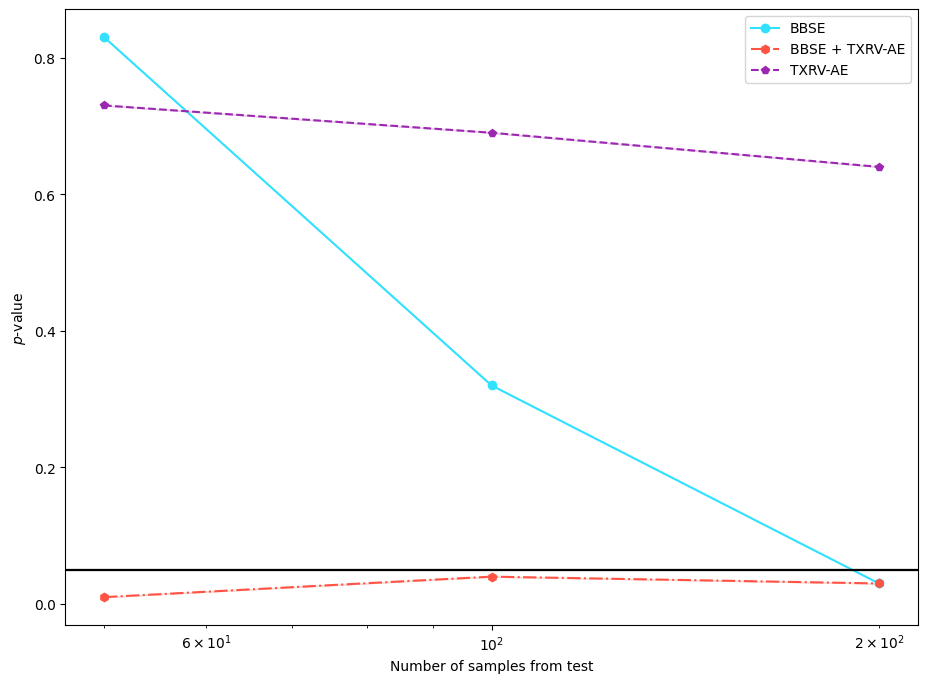

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.17 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.95 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.19 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.35 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.37 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.25 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.71 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.21 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.38 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.59 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.81 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.00 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.70 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.08 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.60 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.56 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.87 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.70 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.05 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.66 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.32 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.75 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.64 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.29 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.13 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.45 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.26 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.56 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.16 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 32.00 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.39 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.28 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.22 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.73 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.27 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.35 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.61 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.39 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.57 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.61 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.08 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.66 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.77 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.89 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.65 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.34 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.77 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.22 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 32.29 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.97 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.37 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.12 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.95 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.05 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.74 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.01 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.22 examples/s]

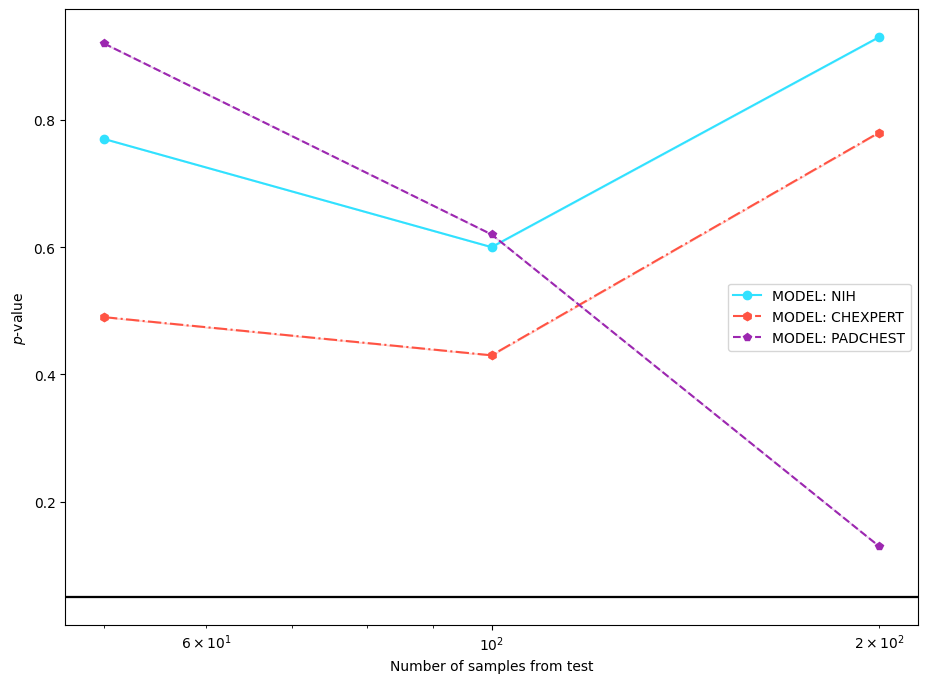

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 57360.64 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 80744.01 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90661.86 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 101489.80 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 102981.29 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 106702.95 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56501.11 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 80653.94 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 92550.51 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 99923.27 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 104412.47 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 108704.76 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.97 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.58 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.21 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.99 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.57 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.21 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.59 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.29 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.25 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.72 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.99 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.35 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.85 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.68 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.84 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.38 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.17 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.69 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.99 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53344.31 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 73776.52 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 85388.26 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 94778.48 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 108070.60 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 118744.02 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51643.49 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 76426.92 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 88337.18 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 97727.48 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 103311.51 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 107343.93 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.86 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.81 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.20 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 50.00 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 55.25 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.49 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.87 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.39 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.74 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.91 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.36 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.75 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.44 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.54 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.82 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.57 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.77 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.03 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.90 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 58496.65 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 82789.62 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 98631.63 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 104545.66 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 106047.28 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 111058.17 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51519.04 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 76275.71 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 94054.01 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 102299.20 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 107098.26 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 109853.70 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.42 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.89 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.80 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.81 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 55.44 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 58.40 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 58.06 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.23 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.05 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.11 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.47 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.12 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.42 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.15 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.62 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.19 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.95 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.65 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.36 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 58050.36 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 82017.23 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 91964.52 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 101214.37 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 105455.11 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 111447.65 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56279.15 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 81028.28 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 94375.19 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 101737.16 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 109818.91 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 112471.88 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.80 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.64 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.16 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.54 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.80 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.03 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.59 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.15 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.22 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.51 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 32.19 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 41.18 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.11 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.92 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.97 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.27 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.19 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.46 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.01 examples/s]

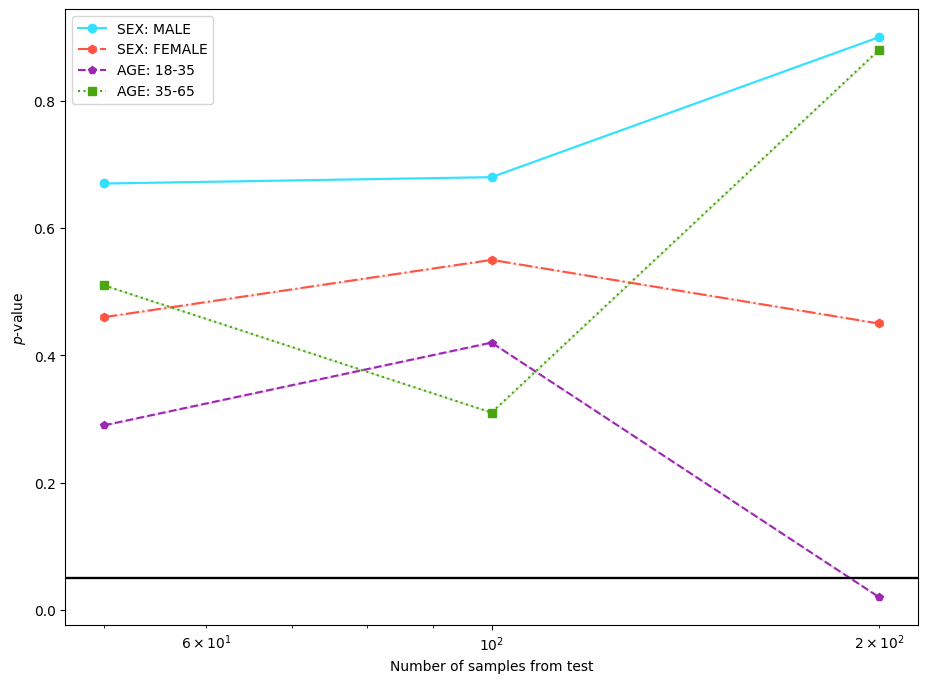

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.96 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:03, 34.30 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.37 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.88 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.23 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.51 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.01 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.19 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 26.95 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.01 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.15 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.73 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.36 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.20 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.35 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.62 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.47 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.89 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.86 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.06 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.86 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.32 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.26 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.40 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.01 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.23 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.04 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.59 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.58 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.66 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 28.08 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.81 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 28.46 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.50 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.78 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.42 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.82 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.04 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.74 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.11 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.53 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.73 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 28.28 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.54 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.92 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.14 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.74 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.63 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.92 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.23 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.62 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.35 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.22 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.45 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.77 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.48 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.56 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.44 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.98 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.46 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.58 examples/s]

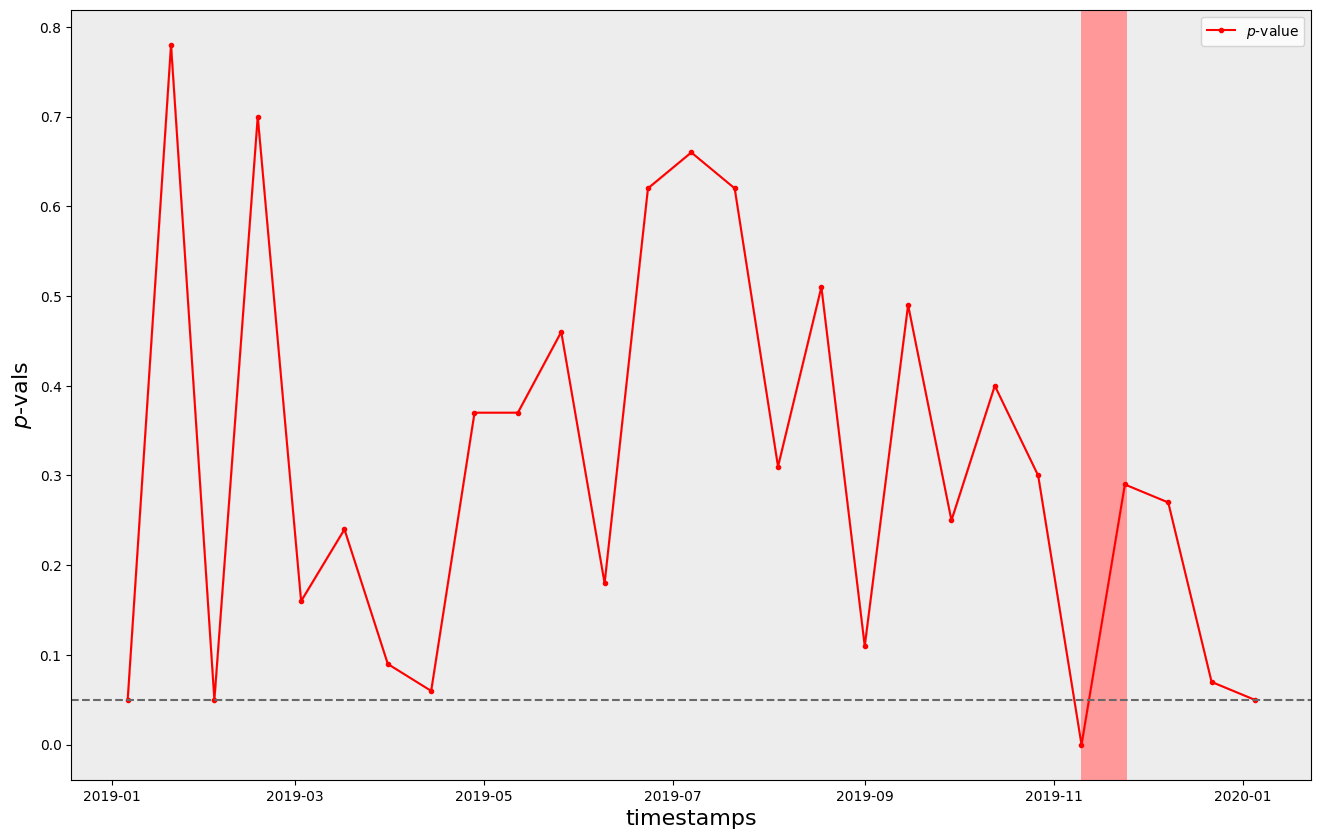

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)